In [1]:
# brew install graphviz
# pip install graphviz
from graphviz import Digraph

In [2]:
from micrograd.engine import Value

In [3]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

Value(data=1.0, grad=0)


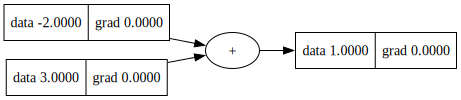

In [4]:
x = Value(-2.0)
y = Value(3.0)
z = x + y 
print(z)
draw_dot(z)

In [5]:
z.backward()
print(x.grad, y.grad)

1.0 1.0


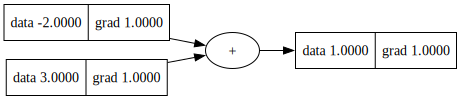

In [6]:
draw_dot(z)

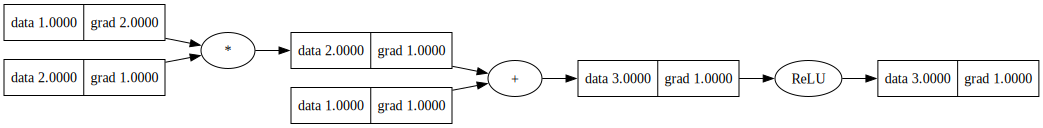

In [7]:
# a very simple example
x = Value(1.0)
y = (x * 2 + 1).relu()
y.backward()
draw_dot(y)

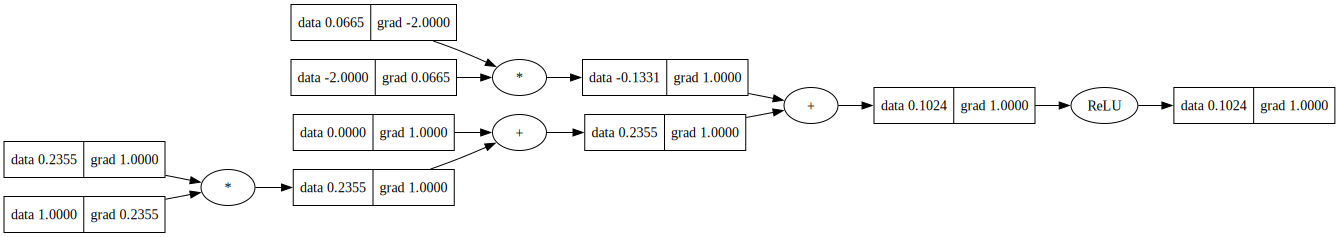

In [8]:
# a simple 2D neuron
import random
from micrograd import nn

random.seed(1337)
n = nn.Neuron(2)
x = [Value(1.0), Value(-2.0)]
y = n(x)
y.backward()

dot = draw_dot(y)
dot

In [9]:
x = Value(-2.0)
y = Value(3.0)
z = x + y
print(z)
w = z.sigmoid()
print(w)

Value(data=1.0, grad=0)
Value(data=0.7310585786300049, grad=0)


In [10]:
w.backward()

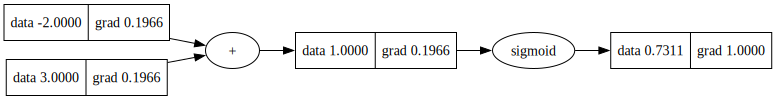

In [11]:
draw_dot(w)

Value(data=0.7615941559557649, grad=0)


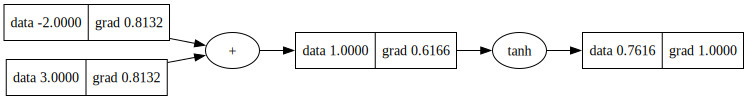

In [12]:
v = z.tanh()
print(v)

v.backward()
draw_dot(v)

In [13]:
import random
from micrograd.engine import Value

class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"


In [15]:
x = Neuron(10, nonlin=True)

In [17]:
print(x)
print(x.nonlin)
print(x.w)
print(x.parameters)

ReLUNeuron(10)
True
[Value(data=0.31255526637777775, grad=0), Value(data=0.8246106857787521, grad=0), Value(data=-0.7814232047574572, grad=0), Value(data=0.6408752595662697, grad=0), Value(data=-0.20252189189007108, grad=0), Value(data=-0.8693137391598071, grad=0), Value(data=0.39841666323128555, grad=0), Value(data=-0.3037961142013801, grad=0), Value(data=-0.19282493884310759, grad=0), Value(data=0.6032250931493106, grad=0)]
<bound method Neuron.parameters of ReLUNeuron(10)>


In [21]:
y = [Value(random.uniform(-1,1)) for _ in range(10)]
z = x(y)

In [25]:
z.backward()

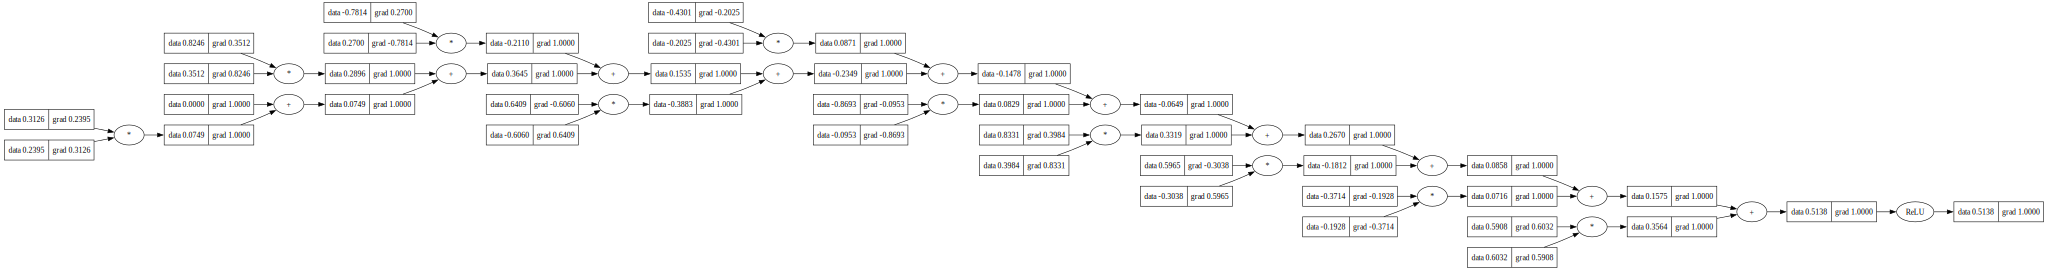

In [27]:
draw_dot(z)

In [28]:
y

[Value(data=0.23949109098065002, grad=0.31255526637777775),
 Value(data=0.35119774963171047, grad=0.8246106857787521),
 Value(data=0.26999576683073867, grad=-0.7814232047574572),
 Value(data=-0.6059558972032326, grad=0.6408752595662697),
 Value(data=-0.4301483303818887, grad=-0.20252189189007108),
 Value(data=-0.09534359352124744, grad=-0.8693137391598071),
 Value(data=0.833061635489087, grad=0.39841666323128555),
 Value(data=0.5964776511293395, grad=-0.3037961142013801),
 Value(data=-0.37143418174288434, grad=-0.19282493884310759),
 Value(data=0.5908148577342738, grad=0.6032250931493106)]

In [5]:
import torch
from micrograd.engine import Value

def test_sanity_check():

    x = Value(-4.0)
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).sigmoid()
    y = h + q + q * x
    y.backward()
    xmg, ymg = x, y

    x = torch.Tensor([-4.0]).double()
    x.requires_grad = True
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).sigmoid()
    y = h + q + q * x
    y.backward()
    xpt, ypt = x, y

    # forward pass went well
    assert ymg.data == ypt.data.item()
    # backward pass went well
    assert xmg.grad == xpt.grad.item()

In [ ]:
test_sanity_check()